In [1]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [29]:
import pickle
import glob
import itertools
from typing import List, Callable

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.settings.tier import Tier
from src.settings.strategy import Strategy

from scipy.stats import ttest_ind

from src.utils.utils import get_generator, get_project_root, make_path_if_not_exists, load_model
from src.utils.metric_utils import adjusted_r2, mean_absolute_percentage_error, median_absolute_percentage_error, mean_absolute_error, mean_absolute_percentage_error
from src.parsers.utils import map_tier, map_strategy, map_architecture

In [15]:
MODE = 'talk'
FIGSIZE = (0, 0)
DPI = 0

# Paper dimensions

# Presentation dimensions
LABEL_SIZE_TALK = 16
DPI_TALK = 96
FIGSIZE_TALK = (13.33, 7.5)
FONTSIZE_TALK = 18

SUITABLE_METABOLITES = ['3pg;2pg', 'dhap', 'f6p', 'pep', 'pyr', 'r5p']
PATH = "/home/tvangraft/tudelft/thesis/metaengineering"

PLOT_KWARGS = {
    'median_ape_error_gt': {
        'x': 'metabolite_id',
        'y': 'median_ape_error_gt',
        'palette': 'colorblind',
    },
    'median_ape_error_fidelity': {
        'x': 'metabolite_id',
        'y': 'median_ape_error_fidelity',
        'palette': 'colorblind',
    },
}

SET_KWARGS = {
    'median_ape_error_gt': {
        'ylabel': 'MAPE of explanation vs gt (%)',
    },
    'median_ape_error_fidelity': {
        'ylabel': 'MAPE of explanation vs model (%)',
    },
}

In [4]:
def get_lime_df(tier: Tier, strategy: Strategy):
    paths = get_explanation_paths("lime", tier, strategy)
    df = pd.concat([pd.read_json(path) for path in paths])
    return df

def get_shap_df(tier: Tier, strategy: Strategy):
    paths = get_explanation_paths("shap", tier, strategy)

    pickled_explanations = {}

    for path in paths:
        with open(path, mode='rb') as shap_explanation:
            clean_path = path.replace(f"/home/tvangraft/tudelft/thesis/metaengineering/explanation/{tier}/shap/{strategy}_", "").replace(".pickle", "")
            pickled_explanations[clean_path] = pickle.load(shap_explanation)

    return pickled_explanations

def get_explanation_paths(type: str, tier: Tier, strategy: Strategy):
    explanation_path = f"/home/tvangraft/tudelft/thesis/metaengineering/explanation/{tier}/{type}"
    paths = glob.glob(f"{explanation_path}/{strategy}_*")
    return paths

def set_context(mode):
    if mode == 'talk':
        sns.set_context(
            "talk",
            rc={
                "font_size": FONTSIZE_TALK,
                "axes.labelsize": LABEL_SIZE_TALK,
            }
        )
        fig = plt.figure(figsize=FIGSIZE_TALK, dpi=DPI_TALK)
        return fig

def save_fig(path: str, name: str):
    make_path_if_not_exists(path)
    plt.savefig(f"{path}/{name}.png", bbox_inches='tight')
    plt.savefig(f"{path}/{name}.svg", bbox_inches='tight')
    
df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)
shap_explanations = get_shap_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)

In [35]:
def make_strategies_plot(df, ax, metric, plot_type: str = 'boxplot'):
    shared_plot_args = dict(
        data=df, x='strategy', y=PLOT_KWARGS[metric]['y'],
        palette='Greys', hue='strategy', dodge=False, ax=ax
    )

    if plot_type == 'boxplot':
        g0 = sns.boxplot(
            **shared_plot_args,
            width=.4,
        )
    elif plot_type == 'violin':
        g0 = sns.violinplot(
            **shared_plot_args,
            inner='point',
        )
    g0.set(
        xticklabels=[],
        xlabel="Strategies",
        **SET_KWARGS[metric]
    )
    g0.tick_params(bottom=False)
    ax.set_title("A", loc="left")
    g0.get_legend().remove()
    return g0

def make_architecture_plot(df, ax, metric):
    g1 = sns.boxplot(
        data=df,
        x='architecture',
        y=PLOT_KWARGS[metric]['y'],
        palette=PLOT_KWARGS[metric]['palette'],
        ax=ax,
        width=.4,
    )
    g1.set(
        xticklabels=[],
        xlabel="Architectures",
        **SET_KWARGS[metric]
    )
    ax.set_title("B", loc="left")
    g1.tick_params(bottom=False)
    # g1.get_legend().remove()
    return g1

def make_metabolite_plot(df, ax, metric):
    g2 = sns.barplot(
        data=df,
        hue='architecture',
        **PLOT_KWARGS[metric],
        ax=ax,
    )

    g2.set_xticklabels(g2.axes.get_xticklabels(), rotation=45)
    g2.set(
        xlabel='Metabolite id',
        **SET_KWARGS[metric]
    )
    ax.set_title("C", loc='left')
    g2.get_legend().remove()
    return g2

def make_legend(ax0, ax2):
    handles, labels = ax0.get_legend_handles_labels()
    leg0 = plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.01, 1.02), title='Strategy', alignment='left')
    ax2.add_artist(leg0)

    handles, labels = ax2.get_legend_handles_labels()
    leg1 = plt.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.01, 0.75), title='Algorithm', alignment='left')
    ax2.add_artist(leg1)
    return (leg0, leg1)

def find_significance(df, column_key:str, metric:str):
    variables = df[column_key].unique()
    for variable_a, variable_b in itertools.combinations(variables, 2):
        list_a = df[df[column_key] == variable_a][PLOT_KWARGS[metric]['y']].values
        list_b = df[df[column_key] == variable_b][PLOT_KWARGS[metric]['y']].values
        print(f"{variable_a=} less than {variable_b=} with {ttest_ind(list_a, list_b, alternative='less')}")
        print(f"{variable_b=} less than {variable_a=} with {ttest_ind(list_b, list_a, alternative='less')}")

# Comparison between shap and lime

In [6]:
full_df = pd.read_csv(f"{PATH}/data/results/all_collected_results.csv", index_col=0)
full_df.strategy = full_df.strategy.map(Strategy.from_str)
full_df.experiment_id = full_df.experiment_id.map(Tier.from_str)
full_df = full_df.rename({ 'y_pred': 'y_pred_model' }, axis=1)

In [20]:
strategies = [Strategy.ALL, Strategy.ONE_VS_ALL, Strategy.METABOLITE_CENTRIC]
tiers = [Tier.TIER0, Tier.TIER1]

def get_shap_prediction(explanation):
    vals = np.abs(explanation.values).mean(0)
    order = np.argsort((-vals))
    explanation = explanation[:, order]
    return explanation.values[:, :100].sum(axis=1) + explanation.base_values

def to_shap_df(shap_explanations, lime_explanations_df):
    result = []

    for _, row in lime_explanations_df.iterrows():
        result.append({
            'metabolite_id': row['metabolite_id'],
            'y_true': row['y_true'],
            'y_pred': get_shap_prediction(shap_explanations[row['metabolite_id']])
        })

    return pd.DataFrame.from_records(result)

lime_result = []
shap_result = []

for tier, strategy in itertools.product(tiers, strategies):
    print(f"{tier=}, {strategy=}")
    # get the lime dataframe
    lime_explanations = get_lime_df(tier, strategy)
    if type(lime_explanations.iloc[0]['y_pred']) != np.float64:
        lime_explanations['y_pred'] = lime_explanations['y_pred'].apply(lambda x: x['metabolite_concentration'])
    lime_explanations_df = pd.merge(
        lime_explanations.groupby(['metabolite_id'])['y_true'].apply(list),
        lime_explanations.groupby(['metabolite_id'])['y_pred'].apply(list),
        left_index=True,
        right_index=True,
    ).reset_index().assign(architecture='lime', experiment_id=tier, strategy=strategy)
    lime_result.append(lime_explanations_df[lime_explanations_df['metabolite_id'].isin(SUITABLE_METABOLITES)])


    # get the shap dataframe
    shap_explanations = get_shap_df(tier, strategy)
    shap_result.append(to_shap_df(shap_explanations, lime_explanations_df).assign(architecture='shap', experiment_id=tier, strategy=strategy))

idx = full_df.groupby(['experiment_id', 'strategy', 'metabolite_id'])['median_ape_error'].transform(max) == full_df['median_ape_error']
_df = full_df[idx][
    ((full_df['experiment_id'] == Tier.TIER0) | (full_df['experiment_id'] == Tier.TIER1))
][['experiment_id', 'strategy', 'metabolite_id', 'y_pred_model']].drop_duplicates().set_index(['experiment_id', 'metabolite_id', 'strategy'])

lime_explanations_df = pd.concat(lime_result)
shap_explanations_df = pd.concat(shap_result)
explanation_df = pd.concat([lime_explanations_df, shap_explanations_df], axis=0)
explanation_df = pd.merge(
    _df,
    explanation_df,
    left_index=True,
    right_on=['experiment_id', 'metabolite_id', 'strategy']
)

explanation_df['y_pred_model'] = explanation_df['y_pred_model'].apply(lambda x: np.fromstring(x.replace('[', '').replace(']', ''), sep=','))
explanation_df['median_ape_error_gt'] = explanation_df.apply(lambda row: median_absolute_percentage_error(row['y_true'], row['y_pred']), axis=1) * 100
explanation_df['median_ape_error_fidelity'] = explanation_df.apply(lambda row: median_absolute_percentage_error(row['y_pred_model'], row['y_pred']), axis=1) * 100

tier=<Tier.TIER0: 'baseline_dataset'>, strategy=<Strategy.ALL: 'full_dataset'>
tier=<Tier.TIER0: 'baseline_dataset'>, strategy=<Strategy.ONE_VS_ALL: 'one_vs_all'>
tier=<Tier.TIER0: 'baseline_dataset'>, strategy=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'>
tier=<Tier.TIER1: 'ppi_dataset'>, strategy=<Strategy.ALL: 'full_dataset'>
tier=<Tier.TIER1: 'ppi_dataset'>, strategy=<Strategy.ONE_VS_ALL: 'one_vs_all'>
tier=<Tier.TIER1: 'ppi_dataset'>, strategy=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'>


Boolean Series key will be reindexed to match DataFrame index.


## Baseline

variable_a=<Strategy.ALL: 'full_dataset'> less than variable_b=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> with Ttest_indResult(statistic=1.074984127476466, pvalue=0.8529846437559964)
variable_a=<Strategy.ALL: 'full_dataset'> less than variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> with Ttest_indResult(statistic=-0.2570232798713049, pvalue=0.39977467763280927)
variable_a=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> less than variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> with Ttest_indResult(statistic=-1.1414412922263069, pvalue=0.13297947546181843)


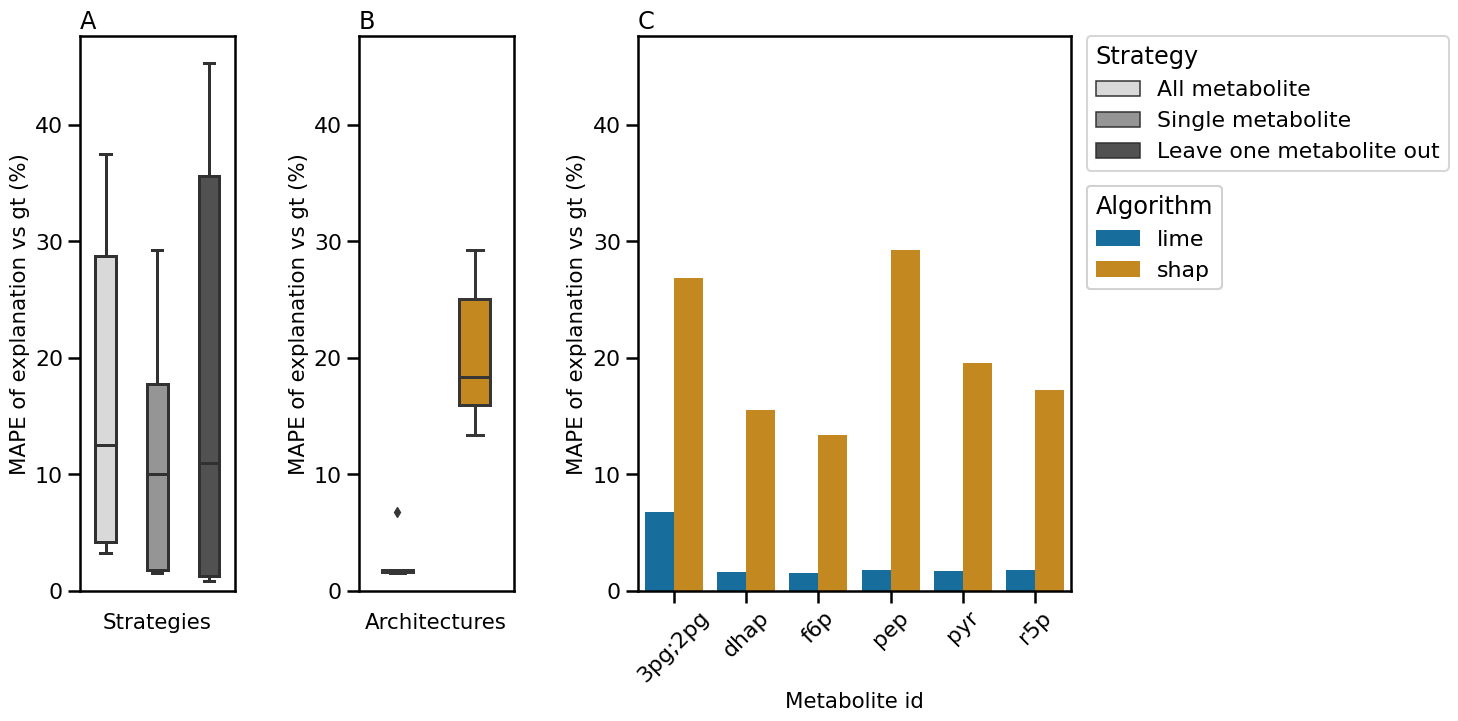

In [33]:
_df = explanation_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER0)]
metric = 'median_ape_error_gt'
find_significance(_df, 'strategy', metric)

fig = set_context(MODE)
NROWS, NCOLS = 1, 4
TIER_0_STRATEGY = Strategy.METABOLITE_CENTRIC
_df = explanation_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER0)]

_df.strategy = _df.strategy.map(map_strategy)

gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
ax2 = fig.add_subplot(gs[0, 2:], sharey=ax0)


metric = 'median_ape_error_gt'
make_strategies_plot(_df, ax0, metric=metric)

# We reset the dataset long live the copy operator
_df = explanation_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER0) & (_df['strategy'] == TIER_0_STRATEGY)]
make_architecture_plot(_df, ax1, metric=metric)
make_metabolite_plot(_df, ax2, metric=metric)
leg0, leg1 = make_legend(ax0, ax2)

variable_a=<Strategy.ALL: 'full_dataset'> less than variable_b=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> with Ttest_indResult(statistic=-1.9698164488538554, pvalue=0.030788542455080753)
variable_b=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> less than variable_a=<Strategy.ALL: 'full_dataset'> with Ttest_indResult(statistic=1.9698164488538554, pvalue=0.9692114575449192)
variable_a=<Strategy.ALL: 'full_dataset'> less than variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> with Ttest_indResult(statistic=2.427869971480852, pvalue=0.988089268757694)
variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> less than variable_a=<Strategy.ALL: 'full_dataset'> with Ttest_indResult(statistic=-2.427869971480852, pvalue=0.011910731242305956)
variable_a=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> less than variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> with Ttest_indResult(statistic=3.4109342857014404, pvalue=0.9987474684440694)
variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> less t

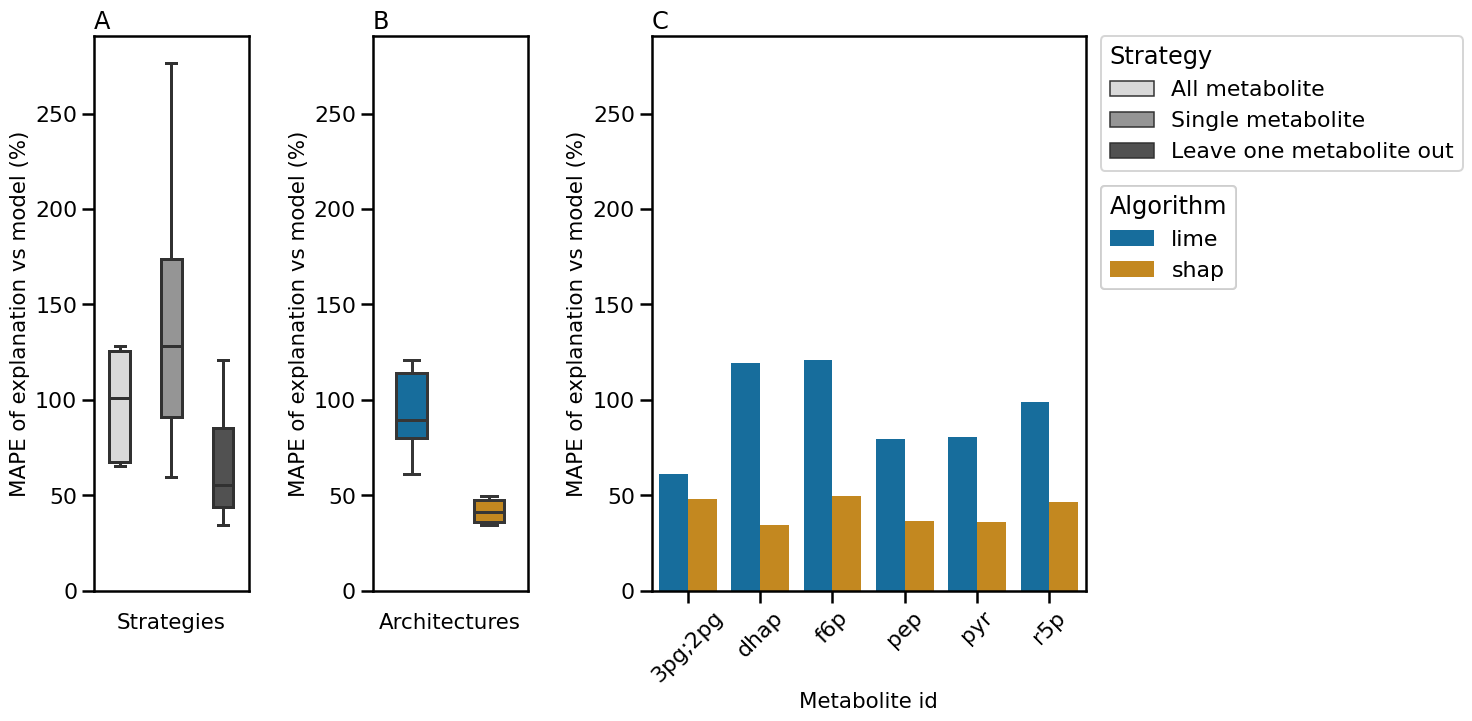

In [37]:
_df = explanation_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER0)]
metric = 'median_ape_error_fidelity'
find_significance(_df, 'strategy', metric)

fig = set_context(MODE)
NROWS, NCOLS = 1, 4
TIER_0_STRATEGY = Strategy.ONE_VS_ALL
_df = explanation_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER0)]

_df.strategy = _df.strategy.map(map_strategy)

gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
ax2 = fig.add_subplot(gs[0, 2:], sharey=ax0)


make_strategies_plot(_df, ax0, metric=metric)

# We reset the dataset long live the copy operator
_df = explanation_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER0) & (_df['strategy'] == TIER_0_STRATEGY)]
make_architecture_plot(_df, ax1, metric=metric)
make_metabolite_plot(_df, ax2, metric=metric)
leg0, leg1 = make_legend(ax0, ax2)

## PPI

variable_a=<Strategy.ALL: 'full_dataset'> less than variable_b=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> with Ttest_indResult(statistic=-0.24305343675379337, pvalue=0.40510792688096353)
variable_b=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> less than variable_a=<Strategy.ALL: 'full_dataset'> with Ttest_indResult(statistic=0.24305343675379337, pvalue=0.5948920731190365)
variable_a=<Strategy.ALL: 'full_dataset'> less than variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> with Ttest_indResult(statistic=0.1153534611491084, pvalue=0.5453943092105996)
variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> less than variable_a=<Strategy.ALL: 'full_dataset'> with Ttest_indResult(statistic=-0.1153534611491084, pvalue=0.45460569078940033)
variable_a=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> less than variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> with Ttest_indResult(statistic=0.35521851551148553, pvalue=0.6370955673396075)
variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> le

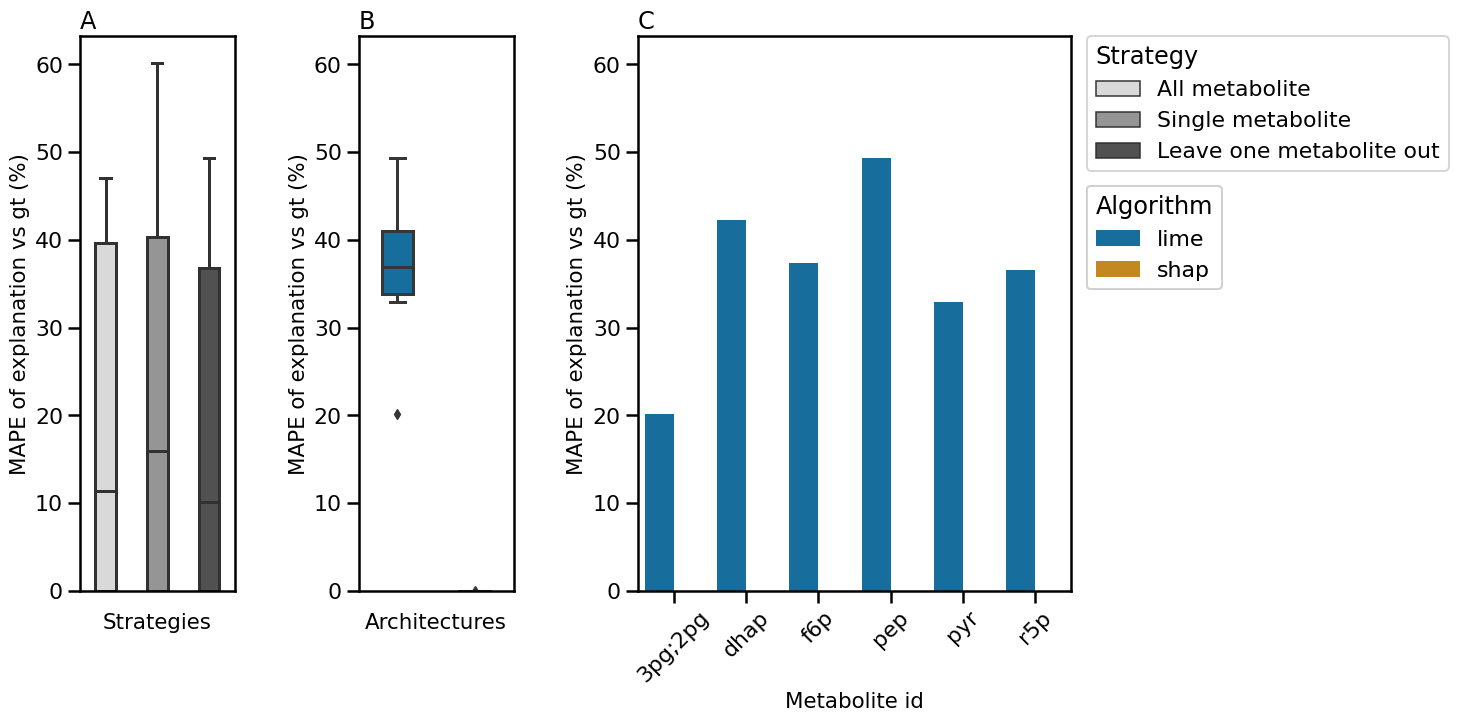

In [40]:
_df = explanation_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER1)]
metric = 'median_ape_error_gt'
find_significance(_df, 'strategy', metric)

fig = set_context(MODE)
NROWS, NCOLS = 1, 4
TIER_1_STRATEGY = Strategy.ONE_VS_ALL
_df = explanation_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER1)]

_df.strategy = _df.strategy.map(map_strategy)

gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
ax2 = fig.add_subplot(gs[0, 2:], sharey=ax0)


metric = 'median_ape_error_gt'
make_strategies_plot(_df, ax0, metric=metric)

# We reset the dataset long live the copy operator
_df = explanation_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER1) & (_df['strategy'] == TIER_1_STRATEGY)]
make_architecture_plot(_df, ax1, metric=metric)
make_metabolite_plot(_df, ax2, metric=metric)
leg0, leg1 = make_legend(ax0, ax2)

variable_a=<Strategy.ALL: 'full_dataset'> less than variable_b=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> with Ttest_indResult(statistic=3.994451790123595, pvalue=0.9996943222108188)
variable_b=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> less than variable_a=<Strategy.ALL: 'full_dataset'> with Ttest_indResult(statistic=-3.994451790123595, pvalue=0.0003056777891811587)
variable_a=<Strategy.ALL: 'full_dataset'> less than variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> with Ttest_indResult(statistic=-0.6738787606082116, pvalue=0.2537037598999755)
variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> less than variable_a=<Strategy.ALL: 'full_dataset'> with Ttest_indResult(statistic=0.6738787606082116, pvalue=0.7462962401000244)
variable_a=<Strategy.METABOLITE_CENTRIC: 'model_per_metabolite'> less than variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> with Ttest_indResult(statistic=-4.582297907791046, pvalue=7.274876392200728e-05)
variable_b=<Strategy.ONE_VS_ALL: 'one_vs_all'> les

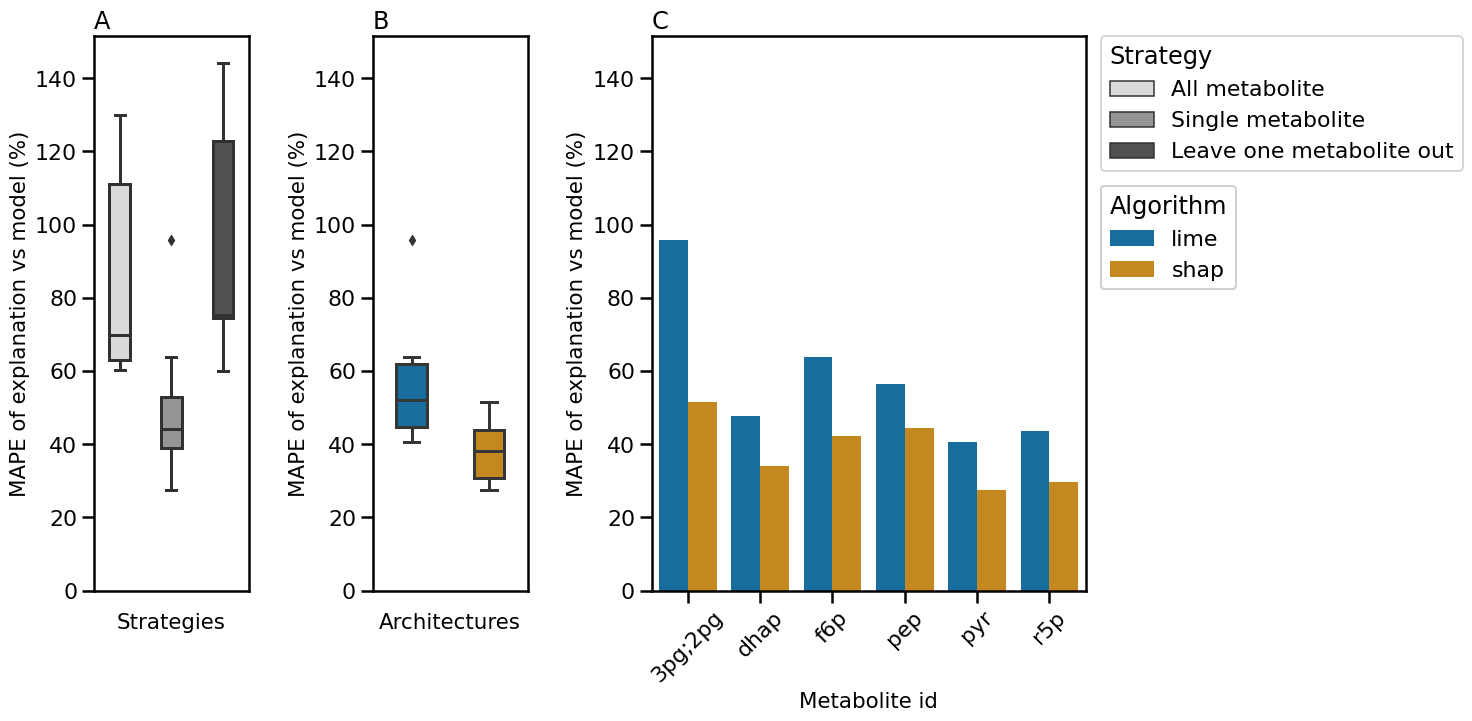

In [42]:
_df = explanation_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER1)]
metric = 'median_ape_error_fidelity'
find_significance(_df, 'strategy', metric)

fig = set_context(MODE)
NROWS, NCOLS = 1, 4
TIER_0_STRATEGY = Strategy.METABOLITE_CENTRIC
_df = explanation_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER1)]

_df.strategy = _df.strategy.map(map_strategy)

gs = fig.add_gridspec(NROWS, NCOLS, wspace=.8)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
ax2 = fig.add_subplot(gs[0, 2:], sharey=ax0)


make_strategies_plot(_df, ax0, metric=metric)

# We reset the dataset long live the copy operator
_df = explanation_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER1) & (_df['strategy'] == TIER_0_STRATEGY)]
make_architecture_plot(_df, ax1, metric=metric)
make_metabolite_plot(_df, ax2, metric=metric)
leg0, leg1 = make_legend(ax0, ax2)

# overlap plot

In [ ]:
def count_overlap(enzymes_one: List, enzymes_two: List):
    idx = 20
    return len(set(enzymes_one[:idx]) & set(enzymes_two[:idx])) / len(enzymes_one[:idx])

def kendalltau(enzymes_one: List, enzymes_two: List):
    from scipy.stats import kendalltau
    return kendalltau(enzymes_one, enzymes_two)[0]

def rank_correlation_metabolite_id(df: pd.DataFrame, metabolite_id: str, agg_func):
    _df = df[df['metabolite_id'] == metabolite_id].set_index('KO_ORF')
    return rank_correlation(_df, agg_func)

def rank_correlation_knockout(df: pd.DataFrame, knockout_id: str, agg_func):
    _df = df[df['KO_ORF'] == knockout_id].set_index('metabolite_id')
    return rank_correlation(_df, agg_func)

def rank_correlation_all(df: pd.DataFrame, agg_func: Callable):
    _df = df.reset_index()
    return rank_correlation(_df, agg_func)

def rank_correlation(_df: pd.DataFrame, agg_func: Callable):
    unique_knockouts = _df.index.to_list()
    knockout_combinations = list(itertools.combinations(unique_knockouts, r=2))
    
    n = len(unique_knockouts)
    r = np.ones((n, n))
    triu = np.triu_indices(n, 1)
    tril = np.tril_indices(n, -1)
    
    key = 'exp_enzymes'
    kendalltau_correllation = [agg_func(_df.loc[left_knockout][key], _df.loc[right_knockout][key]) for (left_knockout, right_knockout) in knockout_combinations]
    
    r[triu] = kendalltau_correllation
    r[tril] = r.T[tril]
    
    return r, unique_knockouts



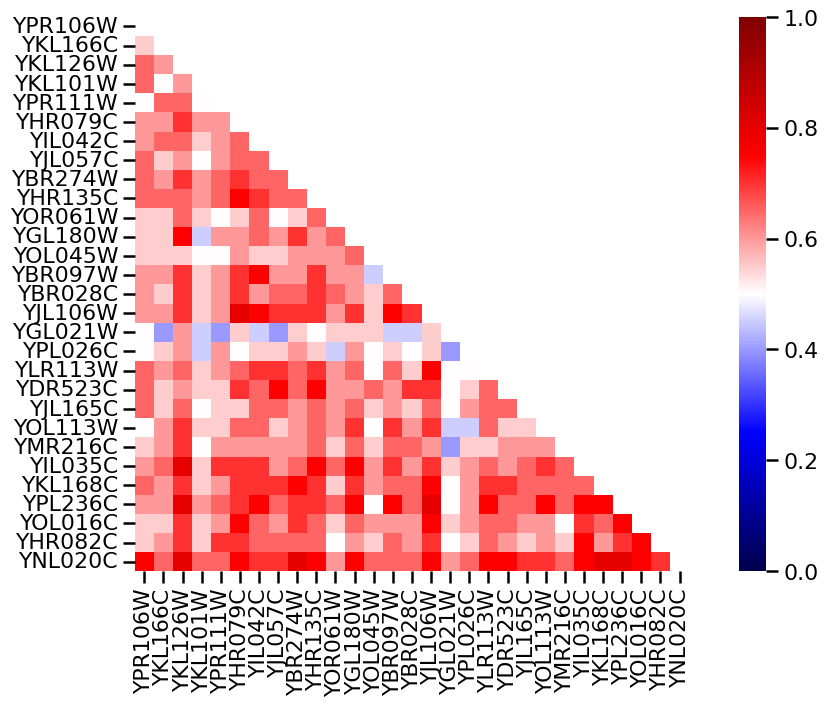

In [ ]:
df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.ALL)
figure = set_context(MODE)
ax = figure.add_subplot(1, 1, 1)
unique_metabolite_id = 'pep'
correlation_matrix, knockouts = rank_correlation_metabolite_id(df, unique_metabolite_id, count_overlap)
sns.heatmap(
    correlation_matrix, 
    square=True, 
    # annot=True,
    # fmt=".2f",
    vmax=1,
    vmin=0,
    ax=ax,
    xticklabels=knockouts,
    yticklabels=knockouts,
    cmap="seismic",
    mask=np.triu(correlation_matrix),
    # cbar=False,
)
plt.savefig(f"./{unique_metabolite_id}.png")
save_fig(path=f'./images/{MODE}/explanation/', name="pyruvate_count_overlap")

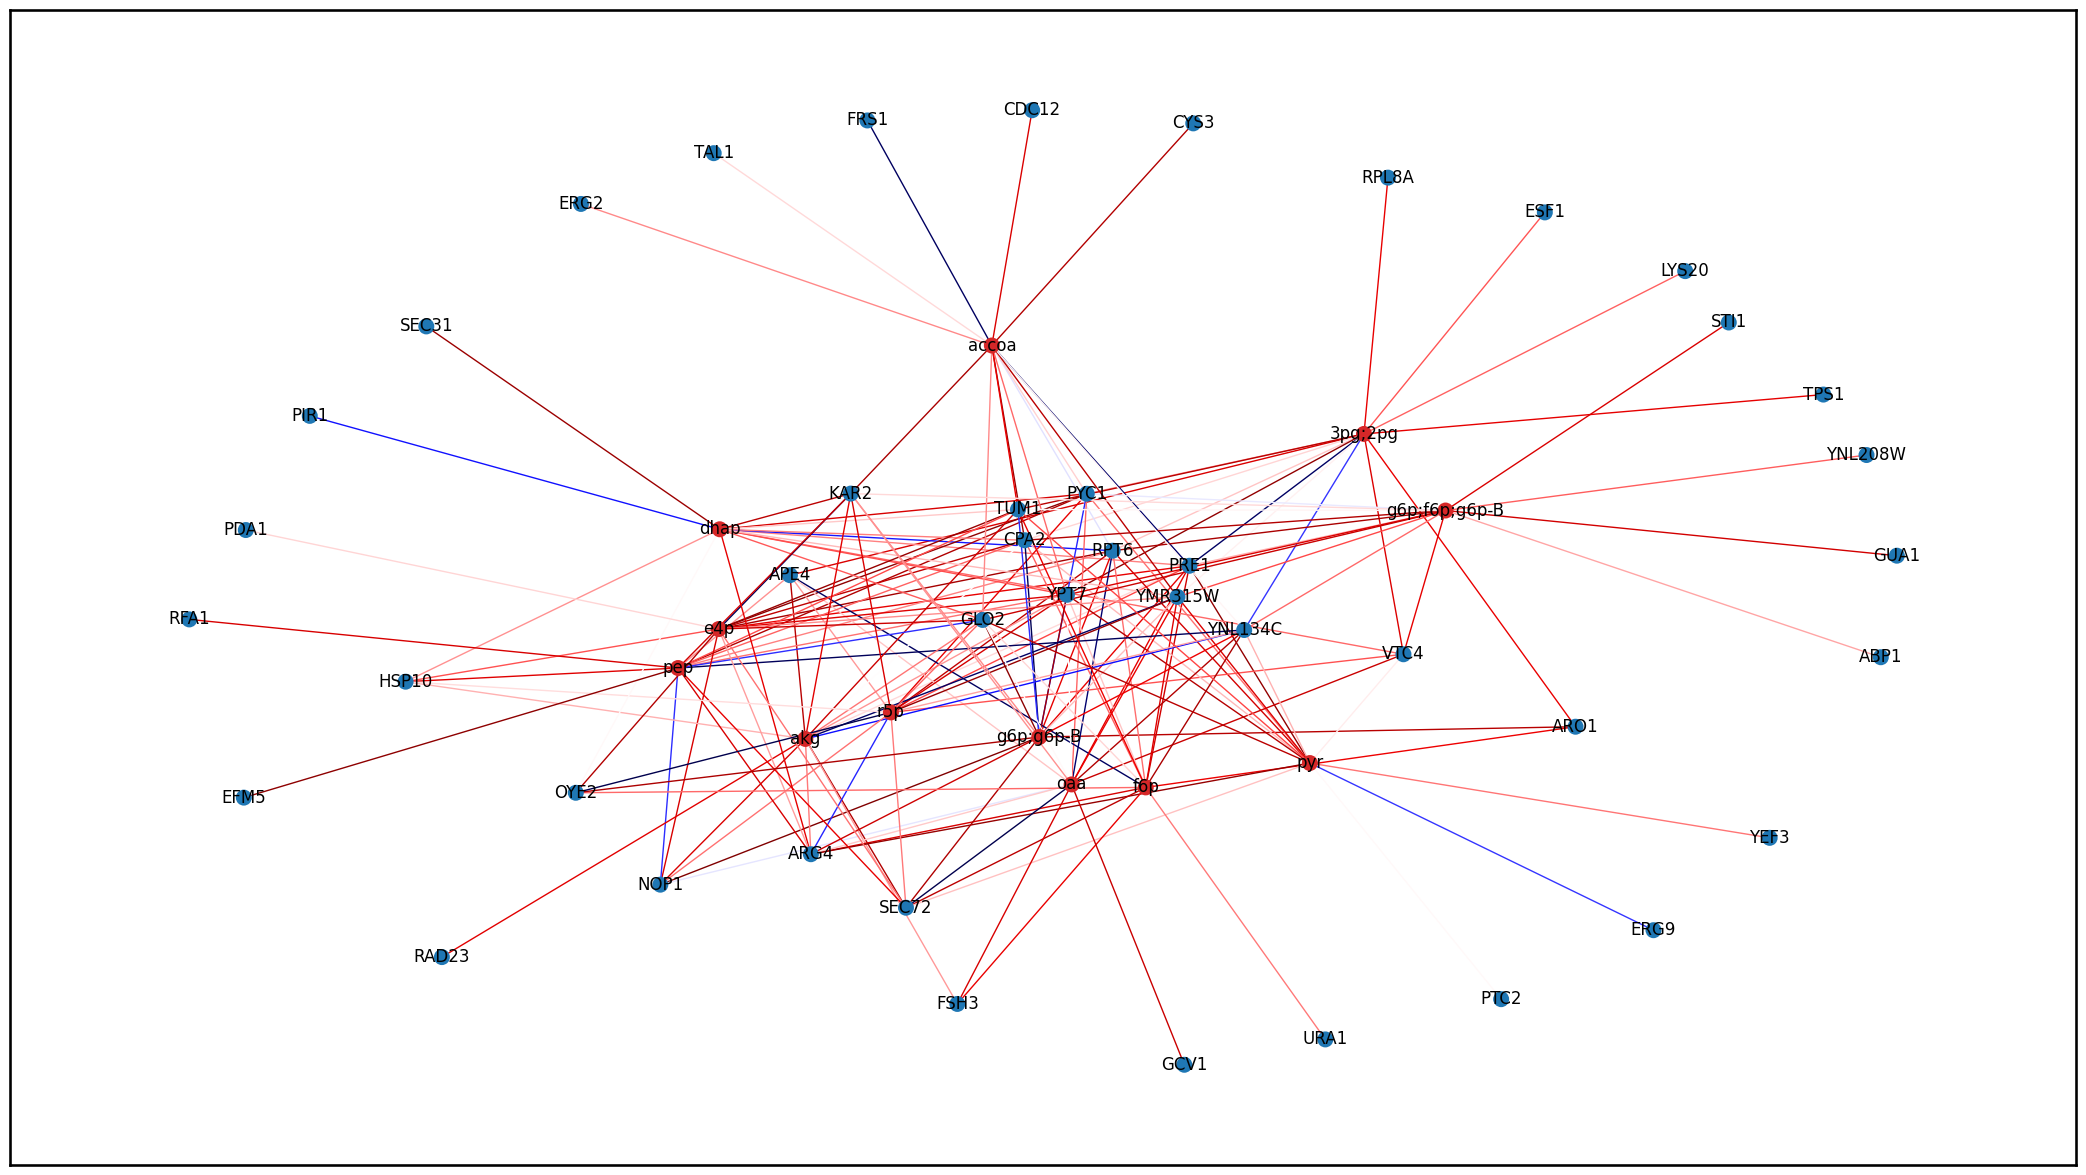

In [ ]:
import networkx as nx

# fig = set_context(MODE)
fig = plt.figure(figsize=(FIGSIZE_TALK[0] * 2, FIGSIZE_TALK[1] * 2))
axgrid= fig.add_gridspec(6, 4)

NROWS, NCOLS = 6, 4
LOWER, MIDDLE, UPPER = int(NROWS / 3), int(2 * NROWS / 3), NROWS
LEFT, RIGHT = int(NCOLS / 2), NCOLS

ax0 = fig.add_subplot(axgrid[:, :])

df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.ALL)
df = df[['metabolite_id', 'exp_enzymes', 'exp_weights']].explode(column=['exp_enzymes', 'exp_weights'])
df = df.groupby(by=['metabolite_id']).head(15).groupby(by=['metabolite_id', 'exp_enzymes']).aggregate(['mean', 'count']).reset_index()

enzyme_nodes = df['exp_enzymes'].unique()
metabolite_nodes = df['metabolite_id'].unique()

lime_explaination_graph = nx.from_pandas_edgelist(df, source='exp_enzymes', target='metabolite_id')
protein_info = pd.read_json("/home/tvangraft/tudelft/thesis/metaengineering/data/training/gene_annotation.json").T.explode('gene_prefered_name').reset_index(names=['orf'])
orf_to_human = protein_info[['orf', 'gene_prefered_name']].set_index('orf').to_dict()['gene_prefered_name']

lime_explaination_graph = nx.relabel_nodes(lime_explaination_graph, orf_to_human)
# pos = nx.nx_agraph.graphviz_layout(lime_explaination_graph)
pos = nx.kamada_kawai_layout(lime_explaination_graph)
pos = nx.rescale_layout_dict(pos, .1)
color_map = ["tab:blue" if node not in metabolite_nodes else "tab:red" for node in lime_explaination_graph]



nx.draw_networkx(
    lime_explaination_graph,
    pos = pos,
    node_size=100,
    ax=ax0,
    node_color=color_map,
    edge_cmap=plt.cm.seismic,
    edge_color=df[('exp_weights', 'mean')].values
)

# from pyvis.network import Network
# net = Network()
# net.from_nx(lime_explaination_graph)
# net.show("example.html")

In [ ]:
from src.utils.stoichiometry_to_graph import get_gene_reaction, is_precursor_metabolite, get_matching_precursor_metabolite, get_edge_list, build_graph_directional
from cobra.util import create_stoichiometric_matrix
import cobra
from src.pipeline.dataloader import DataLoader
from more_itertools import flatten

path = "/home/tvangraft/tudelft/thesis/metaengineering/data"
metabolic_model = cobra.io.read_sbml_model(f'{path}/iMM904.xml')
with open('cobra_metabolites', 'w') as f:
    f.write('\n'.join(create_stoichiometric_matrix(metabolic_model, array_type="DataFrame").index.to_list()))

with open('./data/iMM904.json', 'w') as f:
    f.write(cobra.io.to_json(metabolic_model))


DataLoader.DATA_FOLDER = './data/training/'
dl = DataLoader()
protein_metabolite_df = dl.get_simple_protein_metabolite_dataframe()

ENZYMES = protein_metabolite_df.to_df().columns.to_list()
lime_explaination_graph = nx.from_pandas_edgelist(df, source='exp_enzymes', target='metabolite_id')
protein_info = pd.read_json("/home/tvangraft/tudelft/thesis/metaengineering/data/training/gene_annotation.json").T.explode('gene_prefered_name').reset_index(names=['orf'])
orf_to_human = protein_info[['orf', 'gene_prefered_name']].set_index('orf').to_dict()['gene_prefered_name']

METABOLITES = protein_metabolite_df.obs.columns.to_list()
METABOLITES = [metabolite.replace('-', '__') for metabolite in METABOLITES]
METABOLITES = list(flatten(map(lambda x: str.split(x, ';'), METABOLITES)))

gene_to_reaction, reaction_to_gene = get_gene_reaction(metabolic_model, ENZYMES)
reaction_to_enzyme = pd.MultiIndex.from_tuples(
    [(reaction_id, enzyme_id) for reaction_id, enzymes in reaction_to_gene.items() for enzyme_id in enzymes],
    names=['reaction_id', 'enzyme_id']
)

edge_list_df = get_edge_list(metabolic_model, valid_metabolites=METABOLITES, valid_enzymes=ENZYMES)
metabolite_to_enzyme = pd.MultiIndex.from_frame(
    edge_list_df[['metabolite_id', 'enzyme', 'cardinality']],
    names=['metabolite_id', 'enzyme_id', 'cardinality']
)

reaction_metabolite_enzyme: pd.MultiIndex = metabolite_to_enzyme.join(reaction_to_enzyme)
reaction_metabolite_enzyme = reaction_metabolite_enzyme.reorder_levels(['enzyme_id', 'reaction_id', 'metabolite_id', 'cardinality'])

G_raw = build_graph_directional(reaction_metabolite_enzyme)

explanation_df = get_lime_df(tier=Tier.TIER0, strategy=Strategy.ALL)
explanation_df = explanation_df[['metabolite_id', 'exp_enzymes', 'exp_weights']].explode(column=['exp_enzymes', 'exp_weights'])
explanation_df = explanation_df.groupby(by=['metabolite_id']).head(50).groupby(by=['metabolite_id', 'exp_enzymes']).aggregate(['mean', 'count']).reset_index()
explanation_df

ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[], additional_filters=[])


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


metabolite_id exp_enzymes exp_weights      
                                     mean count
0         3pg;2pg     YAL042W    0.002600     1
1         3pg;2pg     YAR007C    0.002587     1
2         3pg;2pg     YBR078W   -0.002438     1
3         3pg;2pg     YBR115C    0.002470     1
4         3pg;2pg     YBR126C    0.005766     1
..            ...         ...         ...   ...
595           r5p     YOR254C   -0.003967     1
596           r5p     YOR270C   -0.003063     1
597           r5p     YOR310C   -0.003026     1
598           r5p     YPL131W   -0.003111     1
599           r5p     YPR103W    0.003561     1

[600 rows x 4 columns]

In [ ]:
all_paths = []
metabolite_id = 'pyr'
for target_enzyme in explanation_df[explanation_df['metabolite_id'] == metabolite_id].loc[:, 'exp_enzymes'].values:
    if target_enzyme in G_raw:
        if nx.has_path(G_raw, source=metabolite_id, target=target_enzyme):
            paths = list(nx.all_shortest_paths(G_raw, source=metabolite_id, target=target_enzyme))
            for path in paths:
                print(path)
                all_paths.append(path)
        elif nx.has_path(G_raw, target=metabolite_id, source=target_enzyme):
            paths = list(nx.all_shortest_paths(G_raw, target=metabolite_id, source=target_enzyme))
            for path in paths:
                print(path)
                all_paths.append(path)

{'YBR218C', 'PFK_2', 'NDPK7', 'FAS160COA', 'FUMm', 'ILETRS', 'YJR109C', 'CBPS', 'ME2m', 'NDPK3', 'FAS180', 'SHK3Dr', 'NDPK9', 'ADK4', 'ITCOALm', 'YBL076C', 'YHR018C', 'SUCOASm', 'SHKK', 'GK2', 'ASPK', 'HEX1', 'HSK', 'FAS100', 'YDR127W', 'FAS100COA', 'CTPS2', 'FAS140COA', 'FAS140', 'NDPK4', 'PRASCSi', 'ARGSL', 'GK1', 'PSCVT', 'DHAK', 'DHORTS', 'YLR447C', 'MTHFDm', 'DHQTi', 'YNR043W', 'gln__L', 'ATPS3g', 'NDPK8', 'GLNS', 'PFK', 'FAS80COA_L', 'PGK', 'DHQS', 'ADK3', 'FAS80_L', 'ME1m', 'DGK1', 'FAS180COA', 'MTHFCm', 'ATPS', 'GTHS', 'mal__L', 'DPMVD', 'ADSK', 'ANS', 'NDPK1', 'ADNK1', 'FAS160', 'ASPCT', 'NDPK6', 'FTHFLi', 'FAS120COA', 'FUM', 'ADK1', 'MTHFD', 'pyr', 'PRFGS', 'CTPS1', 'NDPK5', 'FAS120', 'CHOLK', 'YGL062W', 'HEX7', 'PYK', 'PFK_3', 'GLUK', 'FTHFLmi', 'ATPS3v', 'MTHFC', 'PC', 'ACCOAC', 'fum', 'HEX4', 'NDPK2'}


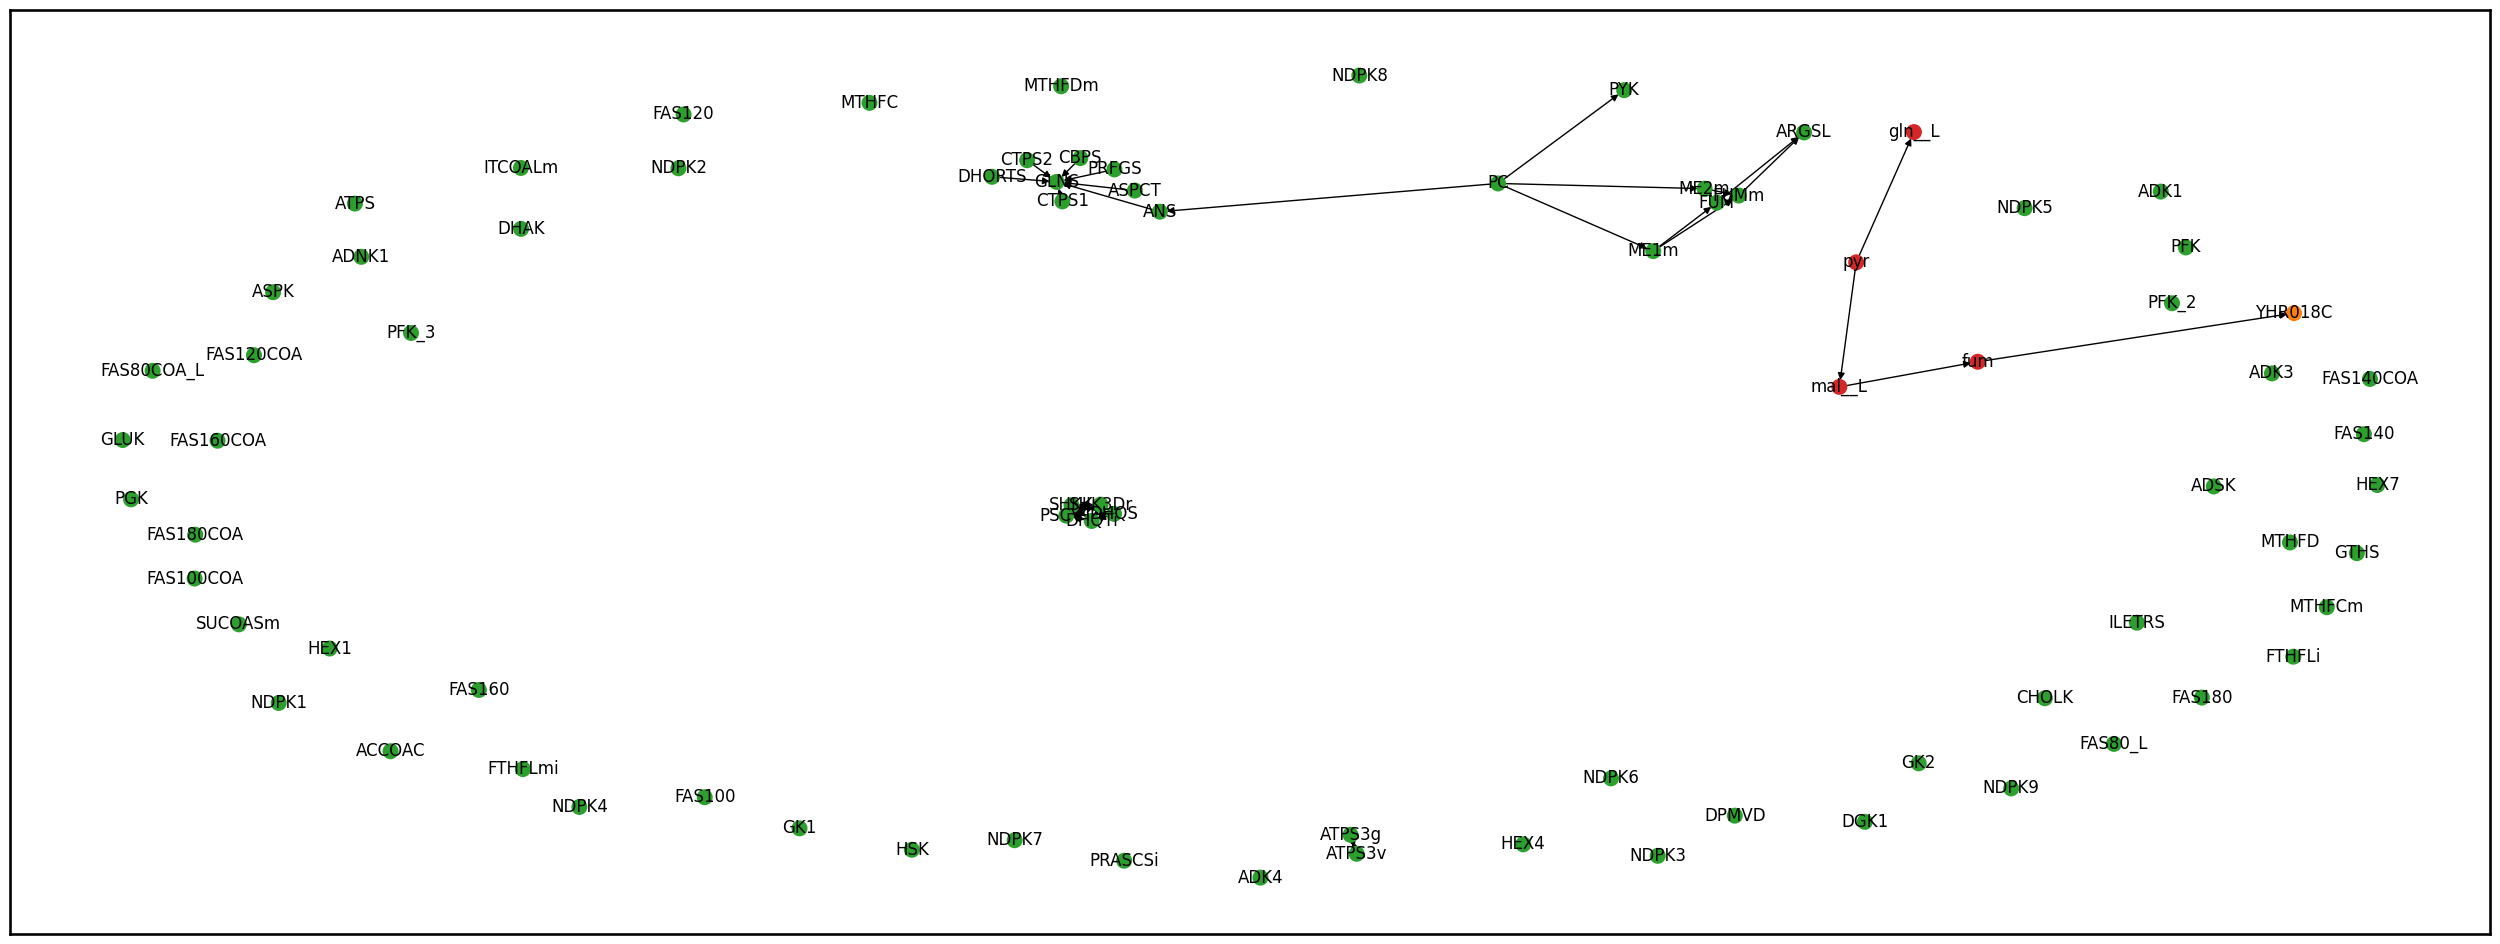

In [ ]:
ENZYME_COLOR = "tab:blue"
METABOLITE_COLOR = "tab:red"
REACTION_COLOR = "tab:green"
def get_color(G, node):
    if 'layer' not in G.nodes[node]:
        return "tab:orange"


    layer = G.nodes[node]['layer']
    if layer == 2:
        return METABOLITE_COLOR   
    elif layer == 1:
        return REACTION_COLOR
    elif layer == 0:
        return ENZYME_COLOR

def get_enzymes_from_path(path):
    enzyme_ids = []
    _t = reaction_metabolite_enzyme.to_frame()
    for node in path:
        enzyme_ids.extend(_t[_t['reaction_id'] == node]['enzyme_id'].values.tolist())
    return enzyme_ids

def filter_explanation_enzymes(nodes, valid_enzymes):
    return [node for node in nodes if node in valid_enzymes]

valid_enzymes = explanation_df[(explanation_df['metabolite_id'] == metabolite_id)]['exp_enzymes'].values.tolist()

nodes = []
for path in all_paths:
    nodes = nodes + path + filter_explanation_enzymes(get_enzymes_from_path(path), valid_enzymes)

nodes = set(nodes)

nodes.remove('atp')
nodes.remove('adp')
nodes.remove('amp')

print(nodes)

G_prime = G_raw.subgraph(nodes)

G_prime = nx.algorithms.bipartite.projected_graph(
    G_prime, 
    [x for x,y in G_prime.nodes(data=True) if y['layer'] == 2 or y['layer'] == 1]
)


pos = nx.spring_layout(G_prime)
fig, ax0 = plt.subplots(1, 1, figsize=(32, 12))
nx.draw_networkx(
    G_prime,
    pos = pos,
    node_size=100,
    node_color=[get_color(G_prime, node) for node in G_prime],
    with_labels=True,
    ax=ax0,
)

In [ ]:
gene_to_reaction['YCR005C']

['CSp']

# Shap analysis

In [ ]:
from shap import KernelExplainer, kmeans, Explanation
from shap.plots import beeswarm, decision, waterfall
import shap

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


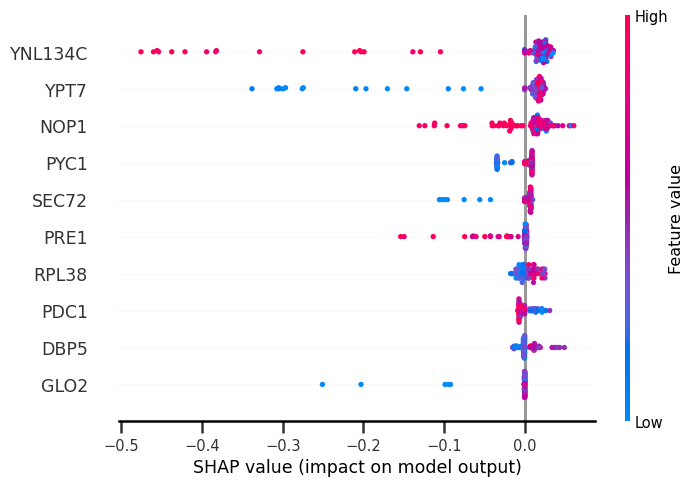

In [ ]:
fig = set_context(MODE)
ax0 = fig.add_subplot(1, 1, 1)

metabolite_id = 'pyr'
strategy = Strategy.ONE_VS_ALL
tier = Tier.TIER0
shap_explanations = get_shap_df(tier=tier, strategy=strategy)
model = load_model(tier=tier, strategy=strategy, metabolite=metabolite_id)

selected_feature_names = [x.replace('num__', '') for x in model.regressor_[:-1].get_feature_names_out()]
protein_info = pd.read_json("/home/tvangraft/tudelft/thesis/metaengineering/data/training/gene_annotation.json").T.explode('gene_prefered_name').reset_index(names=['orf'])
explanation = Explanation(shap_explanations[metabolite_id], feature_names=protein_info[protein_info['orf'] == selected_feature_names]['gene_prefered_name'].values.tolist())
explanation[:, :20]

vals = np.abs(explanation.values).mean(0)
order = np.argsort((-vals))
beeswarm(explanation[:, order][:, :10], max_display=10, show=False)
save_fig(path=f'./images/{MODE}/explanation/', name="pyruvate_single_metabolite_tier_0_explanation")

In [ ]:
explanation_df_lime = get_lime_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)
explanation_df_shap = get_shap_df(tier=Tier.TIER0, strategy=Strategy.METABOLITE_CENTRIC)

In [ ]:
shap.initjs()
explanation = Explanation(explanation_df_shap['pyr'])
shap.force_plot(explanation[0])

In [ ]:
explanation_df_lime[explanation_df_lime['metabolite_id'] == 'pyr']

,KO_ORF,metabolite_id,exp_enzymes,exp_weights,y_true,y_pred
0,YOL016C,pyr,"[YMR110C, YHR018C, YJL140W, YDL110C, YJL012C, ...","[0.0346387518, -0.0304567655, -0.0302864970000...",1.035384,{'metabolite_concentration': 0.8299856047}
1,YKL126W,pyr,"[YHR018C, YJL012C, YCR005C, YDL110C, YLR378C, ...","[-0.0330939184, 0.028751688600000002, -0.02659...",0.819713,{'metabolite_concentration': 0.8297165717}
2,YBR274W,pyr,"[YGL255W, YMR110C, YJL140W, YHR018C, YOR136W, ...","[0.037446544400000004, 0.03620656, -0.03255295...",0.445530,{'metabolite_concentration': 0.4353757287}
3,YKL168C,pyr,"[YMR110C, YGL255W, YLR354C, YHR018C, YOR136W, ...","[0.0364338041, 0.0362981359, 0.0310964526, -0....",1.108804,{'metabolite_concentration': 0.9434500881000001}
4,YDR466W,pyr,"[YGL255W, YJL140W, YMR110C, YHR018C, YJL012C, ...","[0.03632821, -0.035379202400000004, 0.03432878...",0.660057,{'metabolite_concentration': 1.0372479356}
5,YNL307C,pyr,"[YHR018C, YGL255W, YMR110C, YJL140W, YLR354C, ...","[-0.0358497651, 0.034045193700000004, 0.031366...",0.644974,{'metabolite_concentration': 0.6348468094}
6,YKL171W,pyr,"[YGL255W, YHR018C, YLR354C, YBR079C, YOL086C, ...","[0.034764902, -0.0330013439, 0.0303661528, -0....",0.769304,{'metabolite_concentration': 0.7794526572}
7,YAR018C,pyr,"[YGL255W, YJL140W, YHR018C, YJL012C, YBR079C, ...","[0.0366558436, -0.0360788573, -0.0339444275, 0...",-0.473892,{'metabolite_concentration': -0.6341932167000001}
8,YGR092W,pyr,"[YGL255W, YHR018C, YMR110C, YDL110C, YCR005C, ...","[0.036358664, -0.0333881971, 0.0320895158, -0....",1.109656,{'metabolite_concentration': 1.119859641}
9,YJL187C,pyr,"[YMR110C, YHR018C, YGL255W, YLR354C, YLR196W, ...","[0.035174088, -0.0334090435, 0.0328688895, 0.0...",0.874585,{'metabolite_concentration': 0.6824014633000001}


In [ ]:
explanation_df_lime[explanation_df_lime['metabolite_id'] == 'pep']['y_true'].mean()

0.49376438765517244

In [ ]:
explanation.base_values

array([0.58203951, 0.58203951, 0.58203951, 0.58203951, 0.58203951,
       0.58203951, 0.58203951, 0.58203951, 0.58203951, 0.58203951,
       0.58203951, 0.58203951, 0.58203951, 0.58203951, 0.58203951,
       0.58203951, 0.58203951, 0.58203951, 0.58203951, 0.58203951,
       0.58203951, 0.58203951, 0.58203951, 0.58203951, 0.58203951,
       0.58203951, 0.58203951, 0.58203951, 0.58203951])

In [ ]:
explanation_df_shap.keys()

dict_keys(['f6p', 'g6p;g6p-B', 'akg', 'pep', 'dhap', 'pyr', 'g6p;f6p;g6p-B', 'accoa', 'r5p', 'oaa', 'e4p', '3pg;2pg'])

In [ ]:
explanation = Explanation(explanation_df_shap['pep'])
explanation.values.sum(axis=1) + explanation.base_values

array([ 0.11891107,  1.22113035,  0.67666867,  0.53141567,  0.78164193,
        0.44269487,  0.90735189,  0.75269728,  0.55620013,  0.93276285,
        0.79660444,  1.03775045,  0.72228905,  0.64876749, -0.95033096,
        1.00854063,  0.88678576,  0.87036683, -0.48876596,  0.44052401,
        1.01347709,  0.05581463,  0.81533582,  0.92877647, -0.08399861,
       -0.92050834,  0.26631704, -0.38803326,  0.73797991])

# Explanation evaluation

In [ ]:
from src.pipeline.config import DataLoaderConfig, TaskLoaderConfig
from src.pipeline.taskloader import TaskLoader
from src.pipeline.dataloader import DataLoader
from src.pipeline.trainer import Trainer

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, LeavePOut, KFold
from sklearn.metrics import mean_absolute_error, make_scorer, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

In [ ]:
metabolite_id = 'pep'
strategy = Strategy.METABOLITE_CENTRIC
tier = Tier.TIER0
model = load_model(tier=tier, strategy=strategy, metabolite=metabolite_id)
model

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('scaler',
                                                                                                        MinMaxScaler())]),
                                                                                       ['YAL003W',
                                                                                        'YAL005C',
                                                                                        'YAL007C',
                                                                                        'YAL012W',
                                                                                        'YAL035W',
                                                                                        'YAL038W',
                                                                                        'YAL042W',
                                                                                        'YAL044C',
                                                                                        'YAR002C-A',
                                                                                        'YAR007C',
                                                                                        'YAR015W',
                                                                                        'YBL015W',
                                                                                        'YBL024W',
                                                                                        'YBL026W',
                                                                                        'YBL030C',
                                                                                        'YBL039C',
                                                                                        'YBL041W',
                                                                                        'YBL045C',
                                                                                        'YBL050W',
                                                                                        'YBL058W',
                                                                                        'YBL064C',
                                                                                        'YBL076C',
                                                                                        'YBL091C',
                                                                                        'YBL092W',
                                                                                        'YBL099W',
                                                                                        'YBR011C',
                                                                                        'YBR025C',
                                                                                        'YBR026C',
                                                                                        'YBR031W',
                                                                                        'YBR035C', ...])])),
                                                     ('regressor',
                                                      SVR(C=100.0, epsilon=0.01,
                                                          gamma=0.001,
                                                          kernel='sigmoid'))]))

In [ ]:
metabolite_id = '3pg;2pg'
strategy = Strategy.METABOLITE_CENTRIC
tier = Tier.TIER0
model = load_model(tier=tier, strategy=strategy, metabolite=metabolite_id)

model

DataLoader.DATA_FOLDER = f'{get_project_root()}/data/training/'
tier = Tier.TIER0

dl_config = DataLoaderConfig(
    additional_filters=['is_precursor'],
    additional_transforms=["log_fold_change_protein"]
)

dl = DataLoader()
dl.prepare_dataloader(dl_config)

tl = TaskLoader()
tl.prepare_taskloader(TaskLoaderConfig())

gen = get_generator(dl, tl, strategy, tier)

for tf in gen:
    if tf.frame_name == metabolite_id:
        break

print(tf.frame_name)
trainer = Trainer()
split_kwargs = dict(shuffle=False, stratify=None)

X_train, X_test, y_train, y_test = trainer.do_train_test_split(tf, **split_kwargs)

ParsedDataLoaderConfig(additional_frames=[], additional_transforms=[<bound method FrameTransformers.log_fold_change_protein of <src.pipeline.frame.transformer.FrameTransformers object at 0x7f2bf8680c10>>], additional_filters=[<bound method FrameFilters.is_precursor of <src.pipeline.frame.filter.FrameFilters object at 0x7f2bf8680d60>>])
3pg;2pg


In [ ]:
def apply_transform(_model, X):
    _X = X
    for step in _model.regressor_.steps[:-1]:
        _X = step[1].transform(_X)
    return _X

def apply_predict(_model, X):
    return _model.regressor_.named_steps['regressor'].predict(X)

In [ ]:
y_pred = apply_predict(model, apply_transform(model, X_train))

def median_absolute_percentage_error(y_true, y_pred):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    ape = np.abs(y_pred - y_true) / np.abs(y_true)
    return np.median(ape)

print(f"training mae: {mean_absolute_error(apply_predict(model, apply_transform(model, X_train)), y_train)}")
print(f"testing mae: {mean_absolute_error(apply_predict(model, apply_transform(model, X_test)), y_test)}")

training mae: 0.16916044700277405
testing mae: 0.2271041230464944


In [ ]:
-0.356690
-0.353193
-0.353181

-0.353181

In [ ]:
ct = ColumnTransformer([
    ("num", MinMaxScaler(), X_train.columns[1:])
], remainder='drop')

pipeline = make_pipeline(
    ct,
    RandomForestRegressor()
)

scorer = make_scorer(
    median_absolute_percentage_error,
    greater_is_better=False
)

cv = GridSearchCV(
    pipeline,
    {
        'randomforestregressor__n_estimators': [10, 25, 50, 75, 100],
        'randomforestregressor__criterion': ['squared_error', 'friedman_mse'],
        'randomforestregressor__max_depth': [5, 10, 20],
    },
    scoring=scorer,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score='raise',
    # cv=LeavePOut(p=1),
    cv=KFold(n_splits=10),
)

cv.fit(X_train, y_train)
# pd.DataFrame(cv.cv_results_).sort_values(by='rank_test_score')

print(cv.predict(X_test))
print(f"training mae: {mean_absolute_error(cv.predict(X_train), y_train)}")
print(f"testing mae: {mean_absolute_error(cv.predict(X_test), y_test)}")
print(f"testing mdAPE: {median_absolute_percentage_error(y_test, cv.predict(X_test))}")

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[ 0.56211332 -0.27656133  0.40259184  0.20383059  0.61634568  0.64639314
  0.63027081  0.30814808  0.56907441 -0.17951308 -0.00903315  0.23894878
  0.31372989  0.23847943  0.5555743   0.71676491  0.63374716  0.62460518
  0.54261971  0.06031319  0.60437409  0.38447539 -0.13374116 -0.26515118
 -0.79979799  0.74785418  0.17459802  0.60566367  0.12147811]
training mae: 0.17188597080984502
testing mae: 0.4567323380783402
testing mdAPE: 0.4516247722703255


In [ ]:
ct = ColumnTransformer([
    ("num", MinMaxScaler(), X_train.columns[1:])
], remainder='drop')

pipeline = make_pipeline(
    ct,
    SVR()
)

scorer = make_scorer(
    mean_absolute_error,
    greater_is_better=False
)

cv = GridSearchCV(
    pipeline,
    {
        'svr__kernel': ['sigmoid', 'rbf'],
        'svr__gamma': ['auto', 'scale', 0.1, 0.001, 0.01],
        'svr__C': [10, 100, 1000],
        'svr__epsilon': [0.1, 0.01, 0.001, 0.0001],
    },
    scoring=scorer,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score='raise',
    # cv=LeavePOut(p=1),
    cv=KFold(n_splits=10),
)

cv.fit(X_train, y_train)
print(cv.predict(X_test))
print(f"training mae: {mean_absolute_error(cv.predict(X_train), y_train)}")
print(f"testing mae: {mean_absolute_error(cv.predict(X_test), y_test)}")
print(f"testing mdAPE: {median_absolute_percentage_error(y_test, cv.predict(X_test))}")

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[ 0.55178888  0.0022076   0.47403724  0.64932289  0.69218223  0.77947298
  0.43094937  0.19780139  0.64316336  0.51624051  0.76048085  0.59742038
  0.22374859  0.49669957  0.55828038  0.7080397   0.65979297  0.71555566
  0.21299668  0.63662264  0.60610414  0.69732113  0.25341007  0.36947166
 -0.11497606  0.77502242  0.49363259  0.71099614  0.84980059]
training mae: 0.18485608780467205
testing mae: 0.40032637386551206
testing mdAPE: 0.32411578523083756


In [ ]:
ct = ColumnTransformer([
    ("num", MinMaxScaler(), X_train.columns[1:])
], remainder='drop')

pipeline = make_pipeline(
    ct,
    MLPRegressor()
)

scorer = make_scorer(
    mean_absolute_error,
    greater_is_better=False
)

cv = GridSearchCV(
    pipeline,
    {
        'mlpregressor__hidden_layer_sizes': [[128, 32, 32], [64, 32]],
        'mlpregressor__batch_size': [8, 16, 4, 2],
        'mlpregressor__activation': ['relu'],
    },
    scoring=scorer,
    n_jobs=-1,
    refit=True,
    verbose=1,
    error_score='raise',
    # cv=LeavePOut(p=1),
    cv=KFold(n_splits=10),
)

cv.fit(X_train, y_train)
print(cv.predict(X_test))
print(f"training mae: {mean_absolute_error(cv.predict(X_train), y_train)}")
print(f"testing mae: {mean_absolute_error(cv.predict(X_test), y_test)}")
print(f"testing mdAPE: {median_absolute_percentage_error(y_test, cv.predict(X_test))}")

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[ 0.51238438 -0.32983848  0.57188861  0.64680265  0.71205458  0.70977054
 -0.01221189 -0.33741681  0.54065326 -0.14481613  0.47392434  0.81773787
 -0.197631    0.12866415  0.78392555  0.82141596  0.71486877  0.81576542
 -0.4552825   0.5171473   0.59617804  0.77861408 -0.23535398 -0.14222784
 -0.65059703  0.83907307  0.52408608  0.7049858   0.72752135]
training mae: 0.03940878636613835
testing mae: 0.4679242413403405
testing mdAPE: 0.4103274294617046


In [ ]:
cv.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  Index(['YAL003W', 'YAL005C', 'YAL007C', 'YAL012W', 'YAL035W', 'YAL038W',
       'YAL042W', 'YAL044C', 'YAR002C-A', 'YAR007C',
       ...
       'YPR129W', 'YPR133C', 'YPR145W', 'YPR160W', 'YPR163C', 'YPR165W',
       'YPR181C', 'YPR183W', 'YPR187W', 'YPR191W'],
      dtype='object', length=726))])),
                ('mlpregressor',
                 MLPRegressor(batch_size=8, hidden_layer_sizes=[128, 32, 32]))])

In [ ]:
pipeline = cv.best_estimator_
pipeline_apply_predict = lambda _model: lambda X: _model.named_steps['mlpregressor'].predict(X)
def pipeline_apply_transform(X):
    _X = X
    for step in pipeline.steps[:-1]:
        _X = step[1].transform(_X)
    return _X

X_train_summary = shap.kmeans(pipeline_apply_transform(X_train), 4)
ex = shap.KernelExplainer(pipeline_apply_predict(pipeline), X_train_summary)
sv = ex.shap_values(pipeline_apply_transform(X_test), gc_collect=True)
exp = shap.Explanation(sv, np.array([ex.expected_value] * len(X_test)), data=pipeline_apply_transform(X_test), feature_names=selected_feature_names)

  0%|          | 0/29 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
(y_train.mean() + y_test.mean()) / 2

0.36595997167130057

In [ ]:
ex.expected_value

0.5516806743450277

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


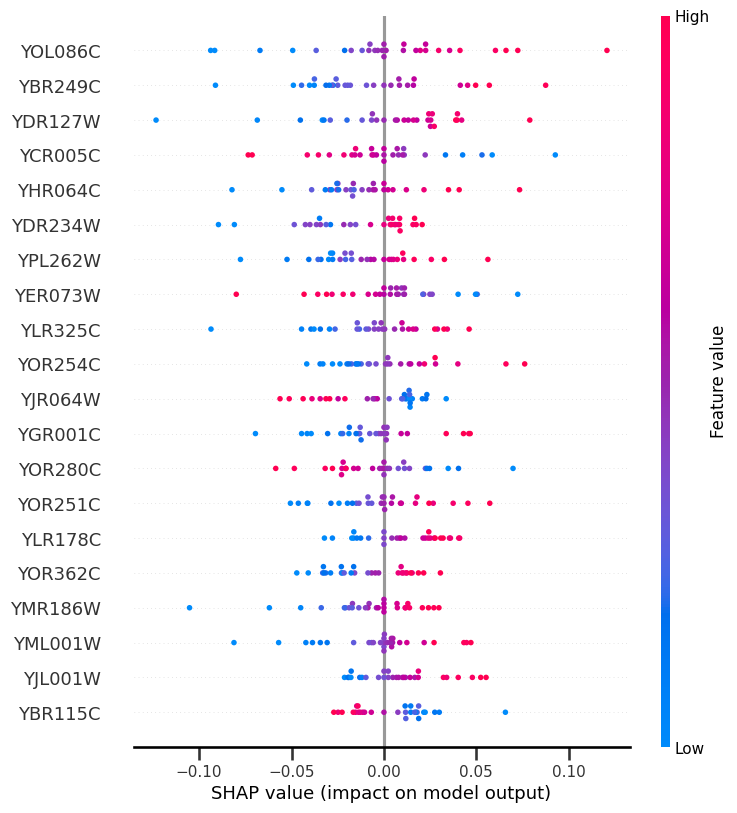

In [ ]:
vals = np.abs(exp.values).mean(0)
order = np.argsort((-vals))
beeswarm(exp[:, order][:, :20], max_display=20, show=False)

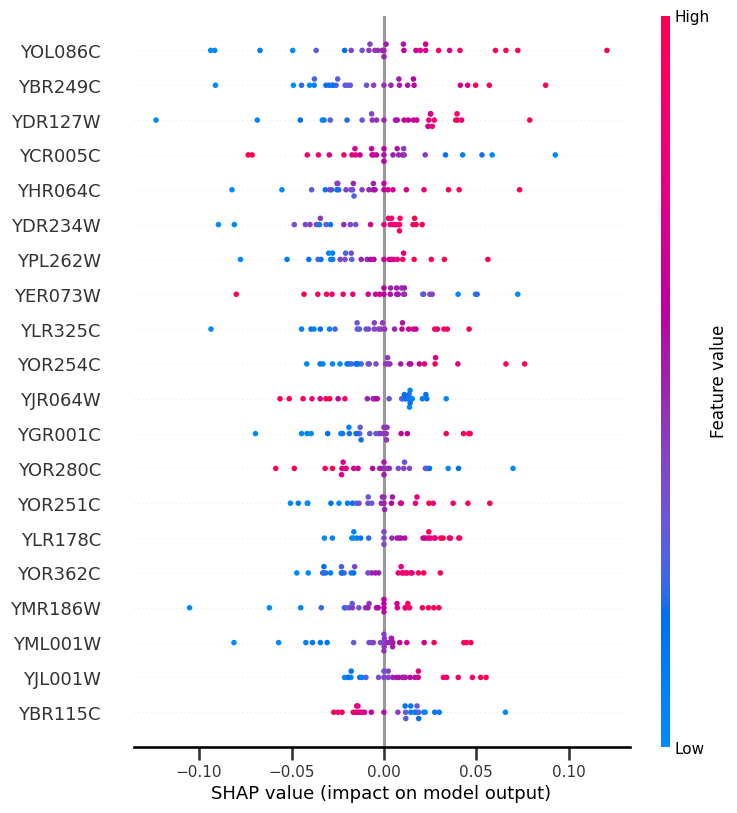

In [ ]:
explanation = Explanation(shap_explanations[metabolite_id], feature_names=protein_info[protein_info['orf'] == selected_feature_names]['gene_prefered_name'].values.tolist())
vals = np.abs(exp.values).mean(0)
order = np.argsort((-vals))
beeswarm(exp[:, order][:, :20], max_display=20, show=False)